In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/papers-by-subject/arXiv-DataFrame.csv


# using LSTMs
Reference: https://www.kaggle.com/code/rahulkumarpatro/multi-class-text-classification-using-lstms

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
# https://stackoverflow.com/questions/72326025/cannot-import-name-pad-sequences-from-keras-preprocessing-sequence
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
df = pd.read_csv('/kaggle/input/papers-by-subject/arXiv-DataFrame.csv',
                usecols=['Title', 'Summary', 'Primary Category', 'Category'])
df['Text'] = df.apply(lambda row: row['Title'] + ' ' + row['Summary'], axis=1)
df.head()

,Title,Summary,Primary Category,Category,Text
0,Dynamic Backtracking,Because of their occasional need to return to ...,cs.AI,['cs.AI'],Dynamic Backtracking Because of their occasion...
1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,cs.AI,['cs.AI'],A Market-Oriented Programming Environment and ...
2,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,cs.AI,['cs.AI'],An Empirical Analysis of Search in GSAT We des...
3,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,cs.AI,['cs.AI'],The Difficulties of Learning Logic Programs wi...
4,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,cs.AI,['cs.AI'],Software Agents: Completing Patterns and Const...


In [4]:
df = df[:2000]

In [5]:
df['Primary Category'].value_counts()

cs.AI    350
cs.AR    350
cs.CC    350
cs.CE    350
cs.CG    350
cs.CL    250
Name: Primary Category, dtype: int64

In [6]:
df.isnull().sum()

Title               0
Summary             0
Primary Category    0
Category            0
Text                0
dtype: int64

## Text preprocessing

In [7]:
space = re.compile('[/(){}\[\]\|@,;]')
symbols= re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = space.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = symbols.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [8]:
df['Text']=df['Text'].apply(clean_text)

In [9]:
df['Text'][0]

'dynamic backtracking occasional need return shallow points search tree eisting backtracking methods sometimes erase meaningful progress toward solving search problem paper present method backtrack points moved deeper search space thereby avoiding difficulty technique developed variant dependencydirected backtracking uses polynomial space still providing useful control information retaining completeness guarantees provided earlier approaches'

In [10]:
maxLen = max([len(x) for x in df['Text']])
maxLen

1943

In [11]:
num_categories = len(np.unique(df['Primary Category']))
num_categories

6

In [12]:
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16310 unique tokens.


In [13]:
X = tokenizer.texts_to_sequences(df['Text'].values)
X = pad_sequences(X, maxlen=3000)

In [14]:
X.shape

(2000, 3000)

In [15]:
Y = pd.get_dummies(df['Primary Category'],columns=df["Primary Category"]).values
Y

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]], dtype=uint8)

In [16]:
len(Y)

2000

In [17]:
Y[0]

array([1, 0, 0, 0, 0, 0], dtype=uint8)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1500, 3000) (1500, 6)
(500, 3000) (500, 6)


## Model

In [19]:
model=Sequential()
model.add(Embedding(50000,100,input_length=3000))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_categories, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 100)         5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 3000, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, Y_train, 
                    epochs=7, 
                    batch_size=64,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', 
                                             patience=3, min_delta=0.0001)])

Epoch 1/7
22/22 [==============================] - 131s 6s/step - loss: 1.7822 - accuracy: 0.2111 - val_loss: 1.7451 - val_accuracy: 0.2533
Epoch 2/7
22/22 [==============================] - 127s 6s/step - loss: 1.5785 - accuracy: 0.4126 - val_loss: 1.3393 - val_accuracy: 0.4200
Epoch 3/7
22/22 [==============================] - 128s 6s/step - loss: 1.0620 - accuracy: 0.6444 - val_loss: 0.9030 - val_accuracy: 0.7067
Epoch 4/7
22/22 [==============================] - 128s 6s/step - loss: 0.7539 - accuracy: 0.7830 - val_loss: 0.8607 - val_accuracy: 0.6933
Epoch 5/7
22/22 [==============================] - 126s 6s/step - loss: 0.4020 - accuracy: 0.9348 - val_loss: 0.6463 - val_accuracy: 0.8133
Epoch 6/7
22/22 [==============================] - 126s 6s/step - loss: 0.3195 - accuracy: 0.9422 - val_loss: 0.7540 - val_accuracy: 0.7600
Epoch 7/7
22/22 [==============================] - 126s 6s/step - loss: 0.1790 - accuracy: 0.9681 - val_loss: 0.5791 - val_accuracy: 0.8333


In [22]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16/16 [==============================] - 8s 526ms/step - loss: 0.6275 - accuracy: 0.8220
Test set
  Loss: 0.628
  Accuracy: 0.822


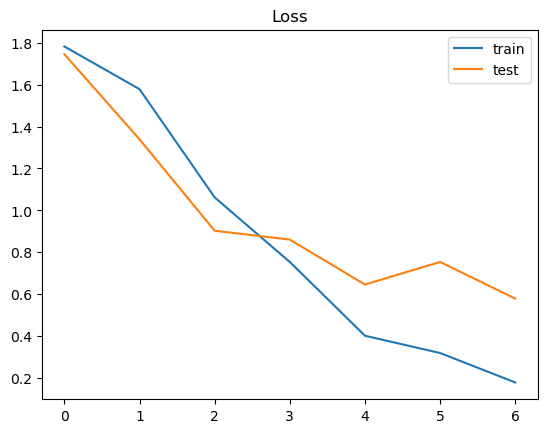

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

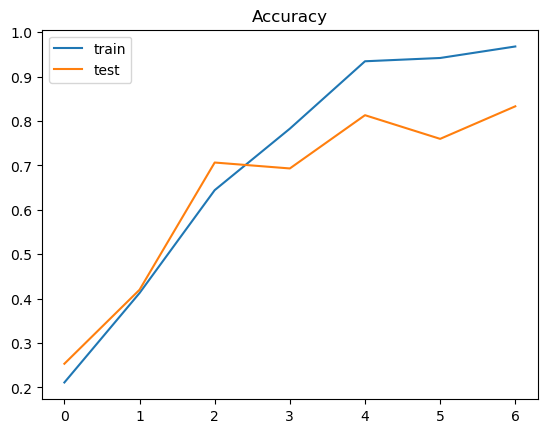

In [24]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [25]:
df['Primary Category'].value_counts()

cs.AI    350
cs.AR    350
cs.CC    350
cs.CE    350
cs.CG    350
cs.CL    250
Name: Primary Category, dtype: int64

In [27]:
# https://www.geeksforgeeks.org/save-and-load-models-in-tensorflow/
# save model
model.save('/kaggle/working/model')
print('Model Saved!')
  
from tensorflow.keras.models import load_model

# load model
savedModel=load_model('/kaggle/working/model')
savedModel.summary()

Model Saved!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3000, 100)         5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 3000, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________
